#   Trabalho de Inteligência Artifical: Classificação

__João Gabriel Miguêz da Silva: 2023008890__

Neste notebook foi utilizado o dataset [Parkinsons Telemonitoring](Phttps://archive.ics.uci.edu/dataset/189/parkinsons+telemonitoring) com o objetivo de classificar o nível de gravidade do Parkinson. 

## Incluindo Bibliotecas

Abaixo teremos todas as bibliotecas que foram usadas neste código assim como as configurações para plotar gráficos

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn - Pré-processamento e Seleção
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Sklearn - Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Sklearn - Métricas
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

# Configuração de plot
plt.style.use('ggplot')

## Carregamento e pré-processamento dos dados

Aqui carregaremos o dataset e usando a mediana iremos transformar um problema de regressão para um problema de classificação binária, também separaremos os dados para teste e treinamento, todos os modelos deste arquivo utilizarão a mesma divisão feitas aqui.

As ações de pré-processamento foram:

1.  Divisão dos dados em treino e teste
2.  Remoção de colunas
3.  Discretização dos dados
4.  Normalização dos dados

In [25]:
#   Carregamento do dataset
parkinsons = pd.read_csv('./parkinsons+telemonitoring/parkinsons_updrs.data')

parkinsons.head()


,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,...,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,...,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,...,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,...,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,...,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


Algumas colunas desse dataset não serão utilizadas por não representarem features preditivas como a identificação do sujeito (coluna subject), o tempo do teste (test_time), entre outras. 

Além disso será necessário "discretizar" os dados, faremos isso através das medianas. Funcinando da seguinte maneira, se o valor estiver acima da mediana, representando um caso `Grave` o valor passa a ser um, senão é um caso `Leve` sendo representado por zero.  

In [40]:

# Criar Target Binário (Classificação)

# 1 = Grave (acima da mediana), 0 = Leve (abaixo da mediana)

mediana_updrs = parkinsons['total_UPDRS'].median()
y = (parkinsons['total_UPDRS'] > mediana_updrs).astype(int)

# Removendo colunas
colunas_remover = ['subject#', 'test_time', 'motor_UPDRS', 'total_UPDRS']
X = parkinsons.drop(colunas_remover, axis=1)

print(f"Shape dos dados: {X.shape}")
print(f"Distribuição das classes:\n{y.value_counts()}")

# Divisão Treino e Teste 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalização (Fit no treino, Transform no teste)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Shape dos dados: (5875, 18)
Distribuição das classes:
total_UPDRS
0    2941
1    2934
Name: count, dtype: int64


## Análise dos dados

Aqui analisaremos como as features se relacionam entre sí, gerando um gráfico de heatmap

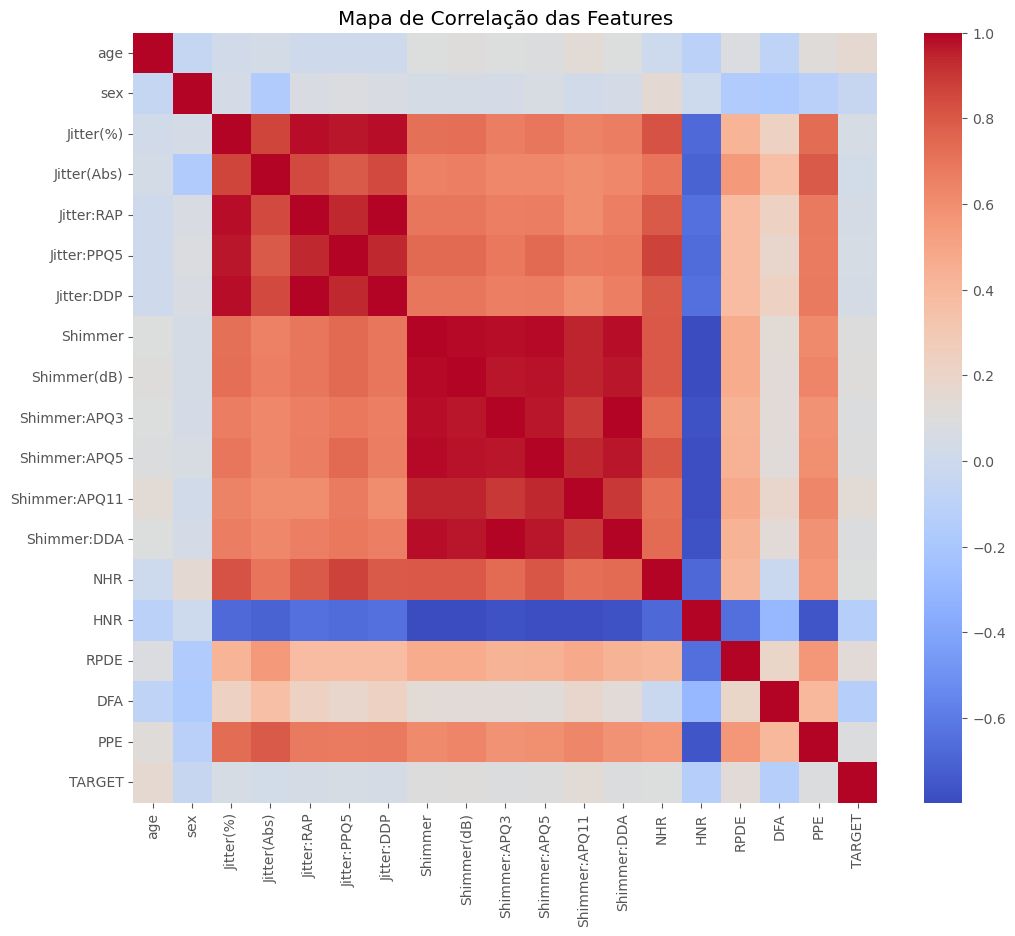

In [41]:
# Reconstruir DataFrame normalizado apenas para visualização
df_eda = pd.DataFrame(X_train_scaled, columns=X.columns)
df_eda['TARGET'] = y_train.values

plt.figure(figsize=(12, 10))
sns.heatmap(df_eda.corr(), annot=False, cmap='coolwarm')
plt.title("Mapa de Correlação das Features")
plt.show()
# [Adicione aqui uma célula de texto explicando o gráfico acima]

Analisando o heatmap podemos observar que a correlação entre as features e os targets é moderada ou baixa

A matriz de correlação revela uma alta multicolinearidade entre as medidas de frequência (Jitter) e amplitude (Shimmer), indicando redundância de informação. Observa-se também uma forte correlação negativa entre HNR (relação harmônico-ruído) e as demais medidas de perturbação, o que é fisicamente esperado.

Crucialmente, a correlação linear das features individuais com a variável alvo (TARGET) é moderada a baixa. Isso sugere que a fronteira de decisão entre casos leves e graves não é trivial, justificando o uso de classificadores não-lineares (como SVM com kernel RBF e Redes Neurais) para capturar a complexidade dos dados

##  Treinamento e Avaliação dos modelos

In [42]:
# DataFrame para armazenar resultados finais
resultados = []

def avaliar_modelo(modelo, nome, X_train, y_train, X_test, y_test):
    # Treino
    modelo.fit(X_train, y_train)
    
    # Predição
    y_pred = modelo.predict(X_test)
    
    # Métricas
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"--- Resultados: {nome} ---")
    print(f"Acurácia: {acc:.4f}")
    print(classification_report(y_test, y_pred))
    
    # Matriz de Confusão
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusão - {nome}')
    plt.ylabel('Real')
    plt.xlabel('Predito')
    plt.show()
    
    # Salvar para comparação final
    resultados.append({
        'Modelo': nome,
        'Acurácia': acc,
        'Precisão': prec,
        'Recall': rec,
        'F1-Score': f1
    })
    return modelo


### Regressão Logistica

--- Resultados: Regressão Logística ---
Acurácia: 0.6324
              precision    recall  f1-score   support

           0       0.63      0.63      0.63       876
           1       0.63      0.64      0.64       887

    accuracy                           0.63      1763
   macro avg       0.63      0.63      0.63      1763
weighted avg       0.63      0.63      0.63      1763



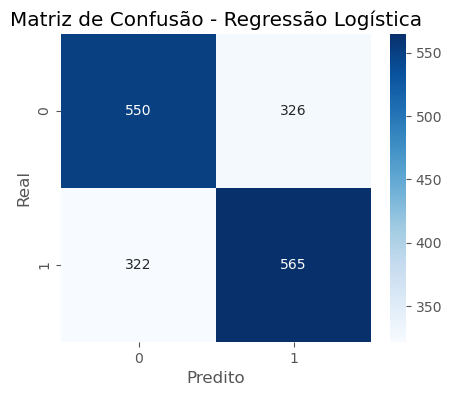

LogisticRegression(max_iter=1000, random_state=42)

In [43]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)
avaliar_modelo(log_reg, "Regressão Logística", X_train_scaled, y_train, X_test_scaled, y_test)

### Support Vector Machine (SVM)

--- Resultados: SVM ---
Acurácia: 0.7748
              precision    recall  f1-score   support

           0       0.78      0.76      0.77       876
           1       0.77      0.79      0.78       887

    accuracy                           0.77      1763
   macro avg       0.77      0.77      0.77      1763
weighted avg       0.77      0.77      0.77      1763



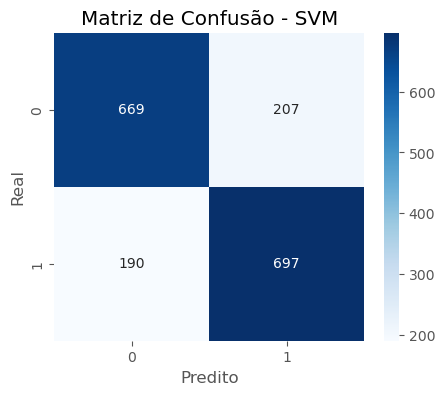

SVC(C=1, random_state=42)

In [44]:
svm_clf = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)
avaliar_modelo(svm_clf, "SVM", X_train_scaled, y_train, X_test_scaled, y_test)

### SVM + PCA

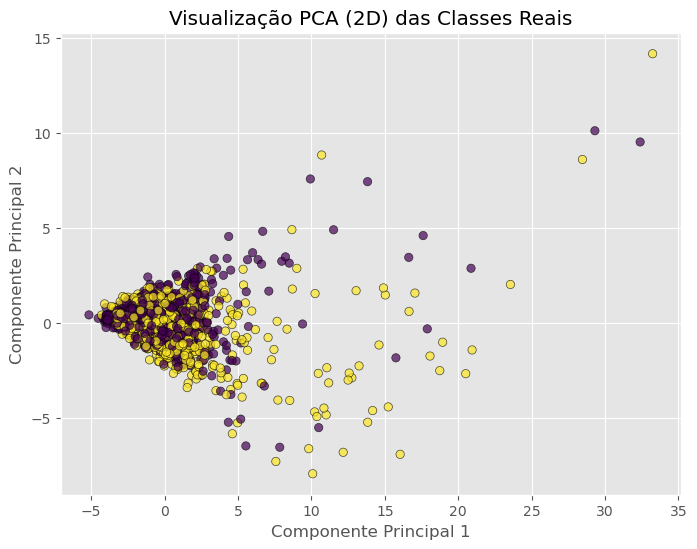

In [45]:
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test_scaled)
plt.figure(figsize=(8,6))
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap='viridis', edgecolor='k', alpha=0.7)
plt.title("Visualização PCA (2D) das Classes Reais")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.show()

### Arvore de decisão

--- Resultados: Árvore de Decisão ---
Acurácia: 0.7737
              precision    recall  f1-score   support

           0       0.79      0.74      0.77       876
           1       0.76      0.80      0.78       887

    accuracy                           0.77      1763
   macro avg       0.77      0.77      0.77      1763
weighted avg       0.77      0.77      0.77      1763



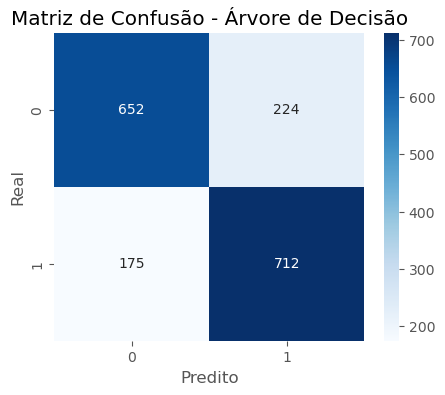

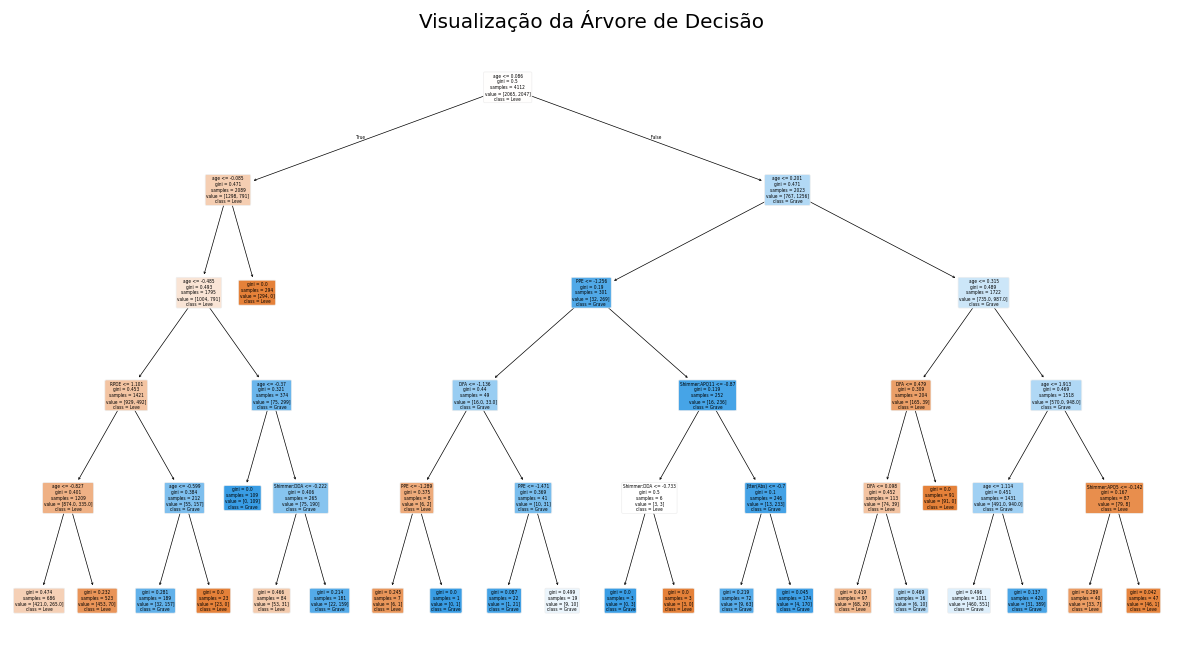

In [46]:
# Árvore não exige normalização necessariamente, mas usaremos os dados scaled para manter padrão
tree_clf = DecisionTreeClassifier(max_depth=5, random_state=42)
modelo_tree = avaliar_modelo(tree_clf, "Árvore de Decisão", X_train_scaled, y_train, X_test_scaled, y_test)

plt.figure(figsize=(15, 8))
plot_tree(modelo_tree, feature_names=X.columns, filled=True, rounded=True, class_names=['Leve', 'Grave'])
plt.title("Visualização da Árvore de Decisão")
plt.show()

### MPL

--- Resultados: MLP ---
Acurácia: 0.8718
              precision    recall  f1-score   support

           0       0.85      0.90      0.87       876
           1       0.89      0.85      0.87       887

    accuracy                           0.87      1763
   macro avg       0.87      0.87      0.87      1763
weighted avg       0.87      0.87      0.87      1763



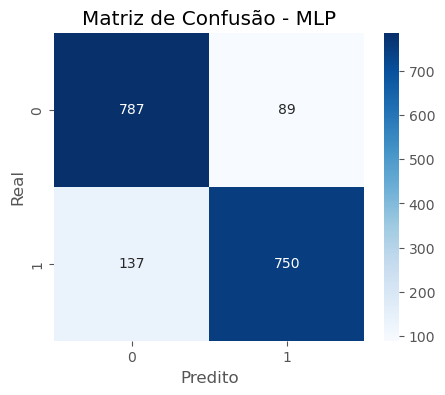

MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)

In [47]:

mlp_clf = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, activation='relu', solver='adam', random_state=42)
avaliar_modelo(mlp_clf, "MLP", X_train_scaled, y_train, X_test_scaled, y_test)

## Comparação e Conclusão



                     Acurácia  Precisão    Recall  F1-Score
Modelo                                                     
Regressão Logística  0.632445  0.634119  0.636979  0.635546
SVM                  0.774816  0.771018  0.785795  0.778336
Árvore de Decisão    0.773681  0.760684  0.802706  0.781130
MLP                  0.871809  0.893921  0.845547  0.869061


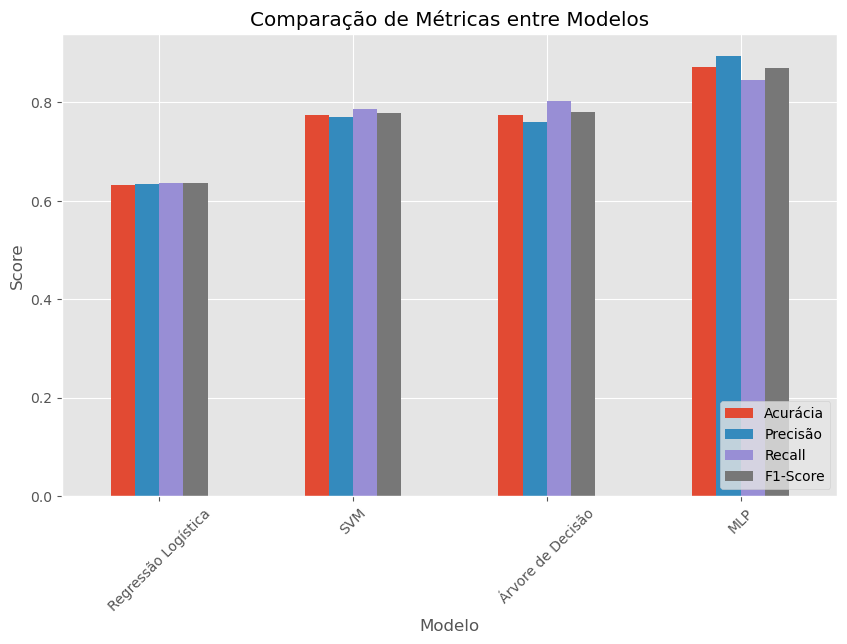

In [48]:
df_resultados = pd.DataFrame(resultados).set_index('Modelo')
print(df_resultados)

# Gráfico comparativo
df_resultados.plot(kind='bar', figsize=(10, 6))
plt.title("Comparação de Métricas entre Modelos")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.show()
